#Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.043 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 30.984 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.023 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 31.008 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 77.062 MiB RAM in 0.688s, peaked 2.234 MiB above current, total RAM usage 108.070 MiB


In [4]:
lens = pd.merge(movies, ratings)

In [4] used 54.027 MiB RAM in 0.179s, peaked 0.000 MiB above current, total RAM usage 162.098 MiB


In [5]:
print(lens[:10])
lens.info()

   movie_id             title                       genres  user_id  rating  \
0         1  Toy Story (1995)  Animation|Children's|Comedy        1       5   
1         1  Toy Story (1995)  Animation|Children's|Comedy        6       4   
2         1  Toy Story (1995)  Animation|Children's|Comedy        8       4   
3         1  Toy Story (1995)  Animation|Children's|Comedy        9       5   
4         1  Toy Story (1995)  Animation|Children's|Comedy       10       5   
5         1  Toy Story (1995)  Animation|Children's|Comedy       18       4   
6         1  Toy Story (1995)  Animation|Children's|Comedy       19       5   
7         1  Toy Story (1995)  Animation|Children's|Comedy       21       3   
8         1  Toy Story (1995)  Animation|Children's|Comedy       23       4   
9         1  Toy Story (1995)  Animation|Children's|Comedy       26       3   

   unix_timestamp  
0       978824268  
1       978237008  
2       978233496  
3       978225952  
4       978226474  
5       97

In [6]:
size_pandas = lens.memory_usage().sum(index=True) / 2**20.
size_pandas

45.785934448242188

In [6] used 0.055 MiB RAM in 0.021s, peaked 0.000 MiB above current, total RAM usage 186.949 MiB


In [7]:
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 39.6 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [7] used 0.234 MiB RAM in 2.011s, peaked 0.000 MiB above current, total RAM usage 187.184 MiB


In [8]:
qtime_pandas = t.best

In [8] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 187.188 MiB


##Use a compressed in-memory container via `bcolz`

In [9]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.9.0
NumPy version:     1.9.2
Blosc version:     1.4.1 ($Date:: 2014-07-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.4.3
Python version:    2.7.10 |Anaconda 2.1.0 (64-bit)| (default, May 28 2015, 17:02:03) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


4

In [9] used 5.895 MiB RAM in 0.085s, peaked 0.000 MiB above current, total RAM usage 193.082 MiB


In [10]:
zlens = bcolz.ctable.fromdataframe(lens)

In [10] used 0.426 MiB RAM in 0.329s, peaked 77.930 MiB above current, total RAM usage 193.508 MiB


Sometimes the memory reported as used is too much biased (don't know why), so let's repeat the operation, but using a different container:

In [11]:
zlens2 = bcolz.ctable.fromdataframe(lens)

In [11] used 0.867 MiB RAM in 0.321s, peaked 77.352 MiB above current, total RAM usage 194.375 MiB


In [12]:
size_bcolz = zlens.cbytes / 2**20

In [12] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 194.375 MiB


In [13]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.89 MB; ratio: 19.45
  cparams := cparams(clevel=5, shuffle=True, cname='lz4')
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [13] used 0.008 MiB RAM in 0.013s, peaked 0.000 MiB above current, total RAM usage 194.383 MiB


In [14]:
size_pandas / size_bcolz

6.5408477783203125

In [14] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 194.383 MiB


We can see that the space taken by a bcolz container is around 7x smaller (!) than a pandas one.

### Excercise

Why do you think that the number of uncompressed bytes (nbytes) that the ctable reports is 3x more than pandas (153 MB vs 54 MB)?

*Hint:* Pandas stores the string columns in NumPy containers with 'object' dtype whereas bcolz uses the equivalent to NumPy's 'string' objects.

In [15]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 25 ms per loop
In [15] used 0.348 MiB RAM in 1.173s, peaked 0.000 MiB above current, total RAM usage 194.730 MiB


In [16]:
qtime_bcolz = t.best

In [16] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 194.730 MiB


In [17]:
qtime_pandas / qtime_bcolz

1.5845635397851394

In [17] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 194.730 MiB


We see that bcolz containers, besides being in compressed state, provide ~2x faster query times than pandas

In [18]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

('results with pandas Dataframe:', 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64)
('results with bcolz ctable:', [(5121, 75), (5164, 3842), (5187, 6031)])
In [18] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 194.730 MiB


## Using structured NumPy arrays

In [19]:
nalens = lens.to_records()

In [19] used 53.418 MiB RAM in 0.593s, peaked 0.000 MiB above current, total RAM usage 248.148 MiB


In [20]:
size_numpy = (nalens.size * nalens.dtype.itemsize) / 2**20

In [20] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 248.148 MiB


In [21]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 16.3 ms per loop


rec.array([ (5121, 8, 'Tom and Huck (1995)', "Adventure|Children's", 75, 5, 977851520),
       (5164, 8, 'Tom and Huck (1995)', "Adventure|Children's", 3842, 5, 967986151),
       (5187, 8, 'Tom and Huck (1995)', "Adventure|Children's", 6031, 5, 956718223)], 
      dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', 'O'), ('genres', 'O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [21] used 0.000 MiB RAM in 6.822s, peaked 0.000 MiB above current, total RAM usage 248.148 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas.

In [22]:
qtime_numpy = t.best

In [22] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 248.148 MiB


##Performance comparsion

In [23]:
%matplotlib inline

In [23] used 7.578 MiB RAM in 0.143s, peaked 0.000 MiB above current, total RAM usage 255.727 MiB


/home/faltet/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


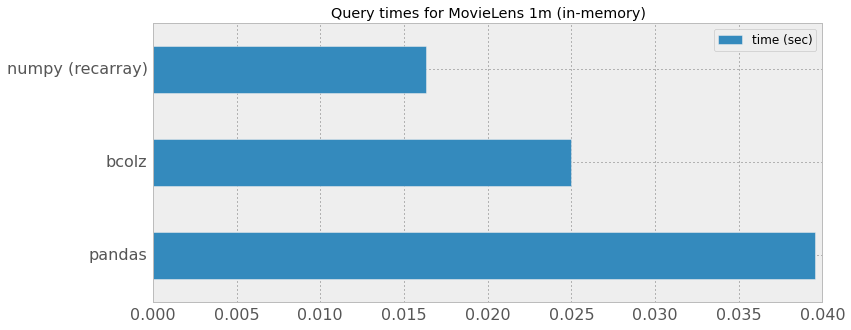

In [24] used 6.680 MiB RAM in 0.326s, peaked 0.000 MiB above current, total RAM usage 262.406 MiB


In [24]:
# Query times
labels = ["pandas", "bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

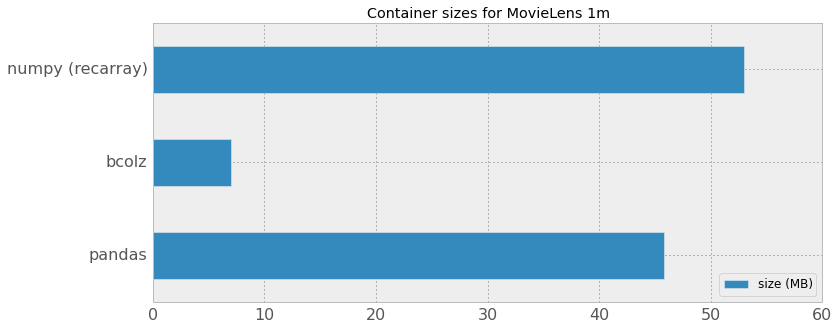

In [25] used 2.699 MiB RAM in 0.280s, peaked 0.000 MiB above current, total RAM usage 265.105 MiB


In [25]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas, size_bcolz, size_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)